# Loan Application Study

## Table of Contents
- [Introduction](#intro)
- [Data Wrangling](#wrangling)
- [Exploratory Data Analysis](#eda)
- [Conclusion of Analysis](#conclusions)
- [Modeling](#modeling)



<a id='introduction'></a>
## Introduction

#### Explanation of the MOS Transistor Behavior (n-channel)

The behavior of an n-channel MOS transistor can be explained as follows:

* When the gate current (Ig) is zero, the drain current (Id), equal to the source current (Is), represents the total current passing through the entire transistor.

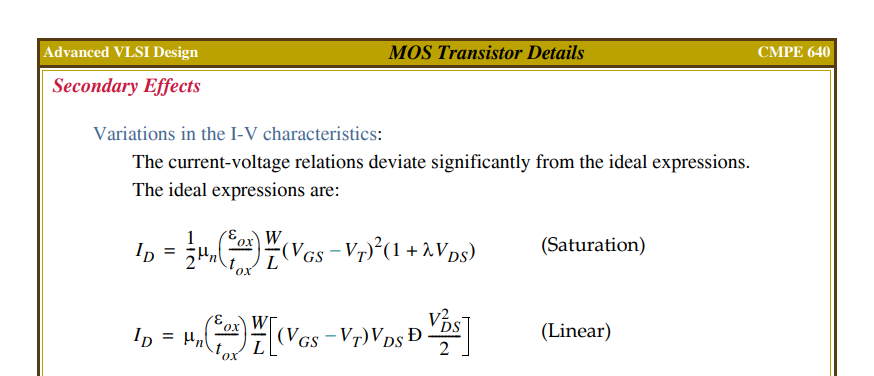

* The value of Id depends on the operating region of the transistor, which is determined by\
the voltages Vgs (gate-source voltage) and Vds (drain-source voltage).
* There are three main regions:


    1. **Cut Off**:
       - If Vgs < Vth (threshold voltage), the transistor is in the "Cut Off" state.
       - Id = 0.

    2. **Triode (Linear)**:
       - If Vgs >= Vth, the transistor turns "ON."
       - In this region, when Vds < Vgs - Vth, the transistor operates in the "Triode" state.
       - Id follows the Linear Law in the image above ☝🏻

    3. **Saturation (Amplifier)**:
       - When Vds > Vgs - Vth in the "ON" state, the transistor is in "Saturation" acting as an **amplifier**.
       - Id follows the Saturation Law in the image above ☝🏻
       
---

### The Challenge 💡
In the complex world of semiconductor physics, predicting transistor current (Id) typically demands numerous features. Our challenge? To harness the power of simplicity. We aim to predict Id using just the following features:

* **vds**: Drain-Source Voltage
* **L(um)**: Length of the transistor (in micrometers)
* **W(um)**: Width of the transistor (in micrometers)
* **drain_length(um)**: Drain length (in micrometers)
* **temperature**: Temperature (in Celsius)
* **vgs**: Gate-Source Voltage
* **vsb**: Source-Body Voltage
    * Vsb can affect the threshold voltage (Vth) and other characteristics.
* **corner**: Categorical corner information
    *  Are used to model the worst-case scenarios of device performance, considering factors like voltage, temperature, and manufacturing process variations.

### Imports & Configrations

In [1]:
# For Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Sklearn imports
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# xgb importing
import xgboost as xgb

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# Other
from tqdm import tqdm
from copy import deepcopy
import pickle

# Configrations
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
np.set_printoptions(formatter={'float_kind': '{:0.4f}'.format})
sns.set()
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
SEED = 1234

# Reading the data
df = pd.read_csv('../Data/simulated_data_nmos.csv')
df.head(2)

,vds,L(um),W(um),drain_length(um),temperature,vgs,vsb,vth,v_pinch_off,lambda(um),id(uA),ig(aA),gm(uS),gmb(uS),ro(Kohm),cgg(aF),cgs(aF),cgd(aF),cdd(aF),cdb(aF),cgb(aF),csb(aF),corner
0,-0.45,8.0,0.84,0.3,27.0,0.0,0.0,0.402306,-0.45,-0.011819,0.034866,0.0,0.659740,0.197561,3181189.42,34032.2445,-28204.1822,-69.122702,88.099279,-4468.20789,-5758.93958,-6638.15046,tt
1,-0.40,8.0,0.84,0.3,27.0,0.0,0.0,0.420865,-0.45,-0.011819,0.009451,0.0,0.196701,0.060563,6552405.05,31291.9536,-24561.0933,-64.892149,80.854021,-3789.70803,-6665.96815,-5628.27847,tt


> Considering only the required features.

In [2]:
df = df[['vds', 'vgs', 'vsb','L(um)', 'W(um)', 'drain_length(um)', 'temperature', 'corner', 'id(uA)']]
df.head(2)

,vds,vgs,vsb,L(um),W(um),drain_length(um),temperature,corner,id(uA)
0,-0.45,0.0,0.0,8.0,0.84,0.3,27.0,tt,0.034866
1,-0.40,0.0,0.0,8.0,0.84,0.3,27.0,tt,0.009451


> Changing the columns names to more easy names

In [3]:
df.rename(columns={
    'L(um)': 'l',
    'W(um)': 'w',
    'drain_length(um)': 'drain_len',
    'id(uA)': 'id'}, inplace=True)
df.head(2)

,vds,vgs,vsb,l,w,drain_len,temperature,corner,id
0,-0.45,0.0,0.0,8.0,0.84,0.3,27.0,tt,0.034866
1,-0.40,0.0,0.0,8.0,0.84,0.3,27.0,tt,0.009451


### Functions we will use

In [4]:
def add_compination_of_features(data):
    """
    Applying some feature engineering on the data to add 
    some compination of origin features
    
    Parameters:
    data (pd.DataFrame): The input DataFrame containing only origin features

    Returns:
    pd.DataFrame: The modified DataFrame with added features
    """
    
    data['w/l'] = data['w'] / data['l']
    data['vgs-vds'] = data['vgs'] - data['vds']
    data['vgs*vds'] = data['vgs'] * data['vds']
    data['vds_squared'] = data['vds'] ** 2
    
    return data

def mean_id_by_column(data, columns, x_rotation=0):
    """
    Visualizes the relationship between specified columns and the average 'id' (transistor current) values.

    Parameters:
        - data (DataFrame): The DataFrame containing the data to be analyzed.
        - columns (list): A list of column names to be analyzed.

    Returns:
        None

    This function groups the data by unique values in the specified columns, calculates the mean 'id' values for each group,
    and creates point plots to compare the relationships between the columns and the average 'id' values in separate subplots.

    Example Usage:
    mean_id_by_column(df_train, ['vgs', 'w', 'l'])
    """
    num_columns = len(columns)
    fig, axes = plt.subplots(num_columns, 1, figsize=(10, 3*num_columns))
    
    
    for i, col in enumerate(columns):
        # Grouping the Id by the unique values of each column
        mean_id_by_column = df_train.groupby(col).mean().id.reset_index()
        
        if col == 'vds':
            '''rounding the vds axis labels to .2f as there is a value
            near to zero but not plotted as zero.'''
            mean_id_by_column[col] = mean_id_by_column[col].round(2)
        
        ax = axes[i]
        
        # Create a point plot to compare mean 'id' values
        sns.pointplot(data=mean_id_by_column, x=col, y='id', label=col, ax=ax)
        ax.set_title(f'Average current per {col}')
        ax.set_ylabel('Average current passes (uA)')
        ax.tick_params(axis='x', rotation=x_rotation)
        

    plt.tight_layout()

## Data Wrangling

### Data Assessing

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871488 entries, 0 to 871487
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   vds          871488 non-null  float64
 1   vgs          871488 non-null  float64
 2   vsb          871488 non-null  float64
 3   l            871488 non-null  float64
 4   w            871488 non-null  float64
 5   drain_len    871488 non-null  float64
 6   temperature  871488 non-null  float64
 7   corner       871488 non-null  object 
 8   id           871488 non-null  float64
dtypes: float64(8), object(1)
memory usage: 59.8+ MB


> * There are `871488` readings for the transistors.
> 
> * There is no missing values in all features.
> 
> * All features are in the type of `float64` except the `corner` is `string`.

In [6]:
# Checking for duplicated rows
print(f'The existance of duplicated rows is: {df.duplicated().any()}')

The existance of duplicated rows is: False


> There is no duplicated radings.

#### Considering numerical features

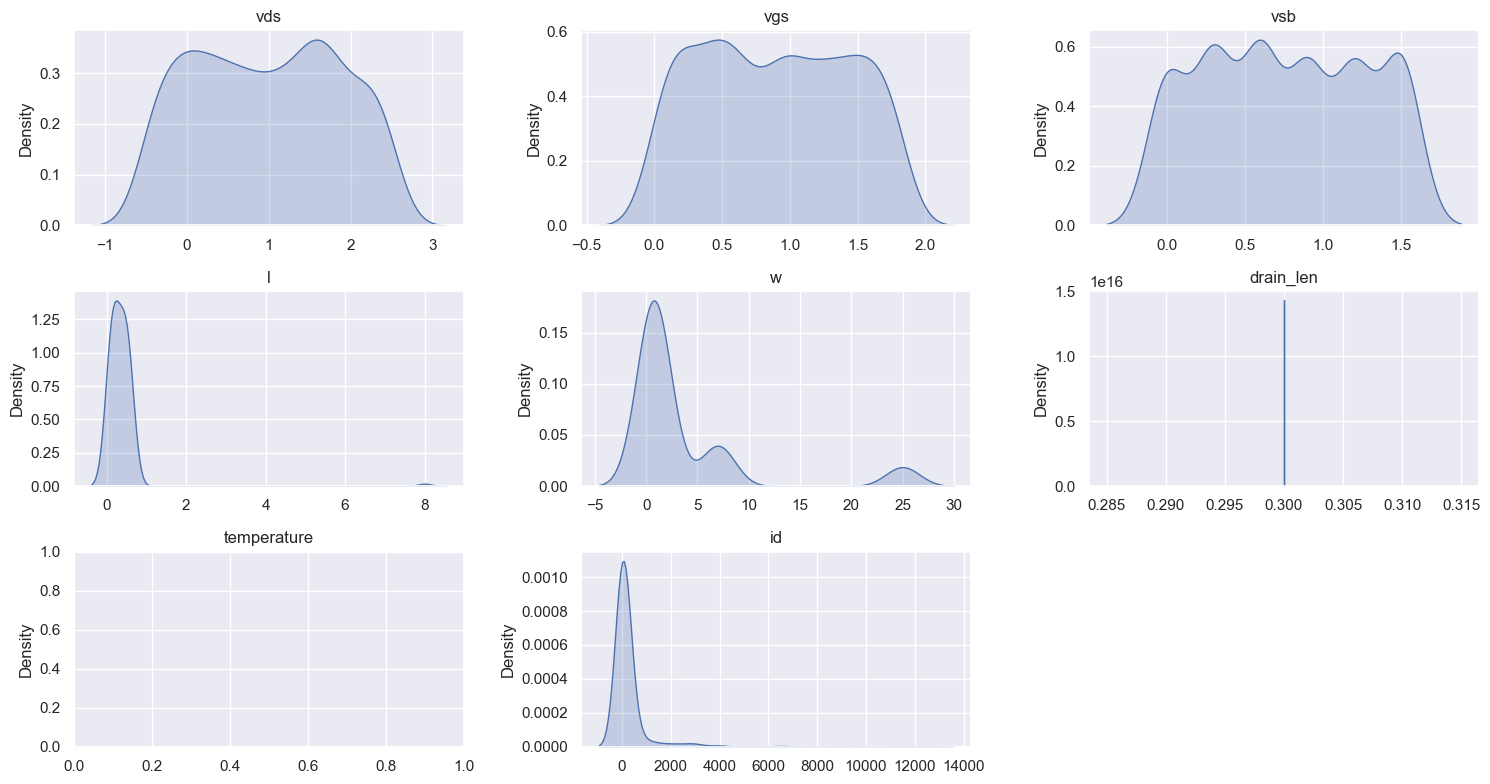

In [7]:
numeric_df = df.select_dtypes(include='number')

plt.figure(figsize=(15, 8))
num_columns = len(numeric_df.columns)

# Creating subplots for each feature's histogram
for i, col in enumerate(numeric_df.columns):
    plt.subplot(3, num_columns // 3 + 1, i + 1)
    sns.kdeplot(numeric_df.sample(1000)[col], shade=True, color='b')
    plt.title(col)
    plt.xlabel("")

plt.tight_layout()

> * **Distribution of the features**
>   - Most of the features exhibit a **Normal Distribution**, suggesting that the data tends to cluster around the mean.
>

> * **Feature Ranges**
>   * The ranges of the features are different. So, we should consdier normalizing them.

> * **Single valued features**
>   * `temperature` & `drain_len` have a single value across the entire dataset, which suggests they may lack discriminatory power for modeling. Consider their relevance for inclusion in the analysis.

> * **Outliers in 'w' Feature**:
>   * Notably, the 'w' feature contains outliers. These values deviate significantly from the majority of data points and may require special consideration in data preprocessing and modeling.

In [8]:
Q1 = df.w.quantile(0.25)
Q3 = df.w.quantile(0.75)
IQR = Q3 - Q1

threshold = 1.5
# Define the lower and upper bounds for outliers
lower_bound = Q1 - threshold * IQR
upper_bound = Q3 + threshold * IQR

df_with_w_outliers_only = df.query(f'w < {lower_bound} or w > {upper_bound}')
print(f'There are {df_with_w_outliers_only.shape[0]} readings that have width considered outlier!')

There are 205123 readings that have width considered outlier!


#### Considering categorical feature `corner`

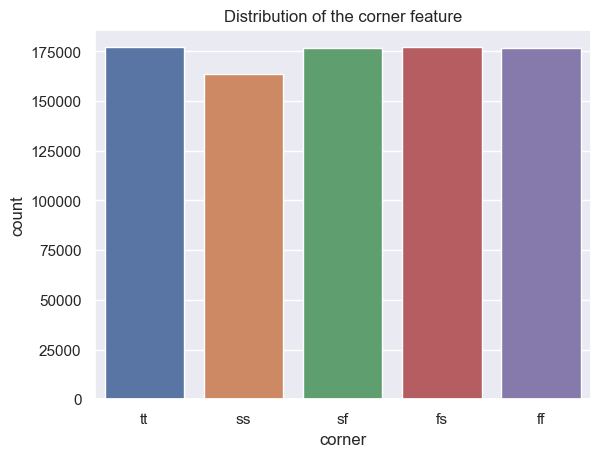

In [9]:
sns.countplot(data=df, x='corner');
plt.title('Distribution of the corner feature');

> * They are distibuted slightly equally on the dataset. 
>
> * As they are just 5 unique features, we could One Hot Encoding them.

### Data Cleaning

> First lets drop the single values features

In [10]:
df.drop(columns=['temperature', 'drain_len'], inplace=True)

> We will make some transformation on the data such as, standarizing it and converting the categorical values into numerical values `in the modeling phase after the EDA.`

---

## Exploratory Data Analysis (EDA)

> In this exploratory data analysis phase, we will strive to answer several important questions that will\
aid our understanding of the dataset and inform our modeling process.

> **The questions we aim to address are as follows:**
> 1. How does the average current ('id') change with varying width 'w' and length 'l'?
> 2. How does the average current ('id') change with varying width ('vgs'), back-gate voltage ('vsb'), and drain-source voltage ('vds')?
> 3. What is the relationship between average current ('id') and the categorical feature 'corner'?
> 4. Which features are the best predictors for the current value?

> **Splitting the data into train & test.**
> 
> The data was split into training and testing sets before EDA to ensure complete test set independence and facilitate parameter tuning without any test set insights.

In [124]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=SEED)
df_train.head(2)

,vds,vgs,vsb,l,w,corner,id
801381,1.35,0.1,1.5,0.5,0.65,ff,8.561236e-10
770725,-0.45,0.9,0.9,0.5,0.36,ff,3.424492e+01


#### Q1) How does the average current ('id') change with varying width 'w' and length 'l'?

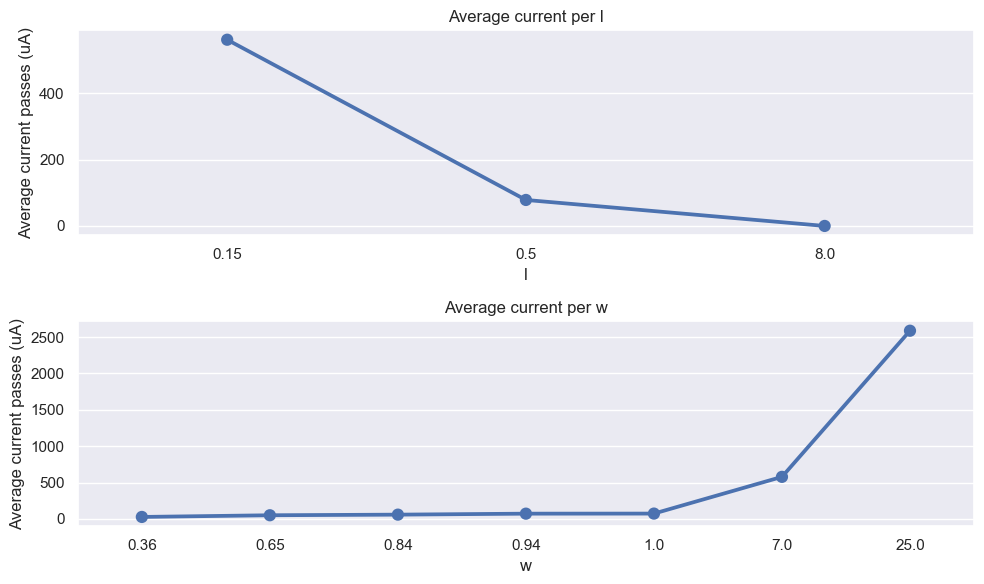

In [125]:
mean_id_by_column(df_train, ['l', 'w'])

> * **Length (l):**
>   * Increasing the length (L) results in a decrease in the average current passing through the transistor.
>   * When the length is 0.8 µm, the current drops to zero.
> * **Width (w):**
>   * For widths less than 1 µm, no current passes through the transistor.
>   * Once the width exceeds 1 µm, the average current starts to increase.

#### Q2) How does the average current ('id') change with varying width vgs, vsb, and the vds?

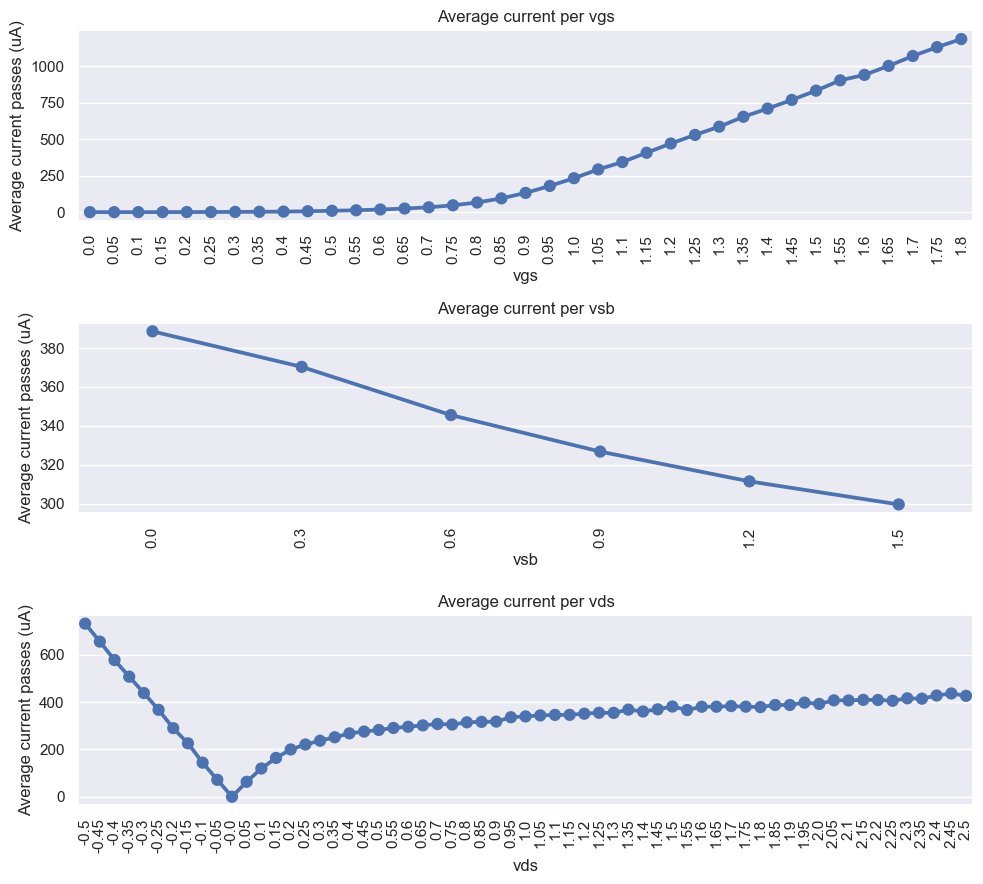

In [126]:
mean_id_by_column(df_train, ['vgs', 'vsb', 'vds'], x_rotation=90)

> * **Gate-Source Voltage ('vgs'):**
>   * For 'vgs' values below 0.7, 'id' remains close to 0. This voltage threshold (Vth) indicates that the transistor does not conduct current until a certain gate-source voltage is applied.
>   * The current remains at 0 until 'vgs' reaches 0.7, after which it starts to exhibit either a linear or exponential behavior.
> * **Source-Body Voltage ('vsb'):**
>   * An increase in 'vsb' results in a decrease in the average current passing through the transistor.
> * **Drain-Source Voltage ('vds'):**
>   * For negative values of 'vds', the current exhibits a linear decrease. It eventually reaches zero current at 'vds' equals 0 and then begins to increase logarithmically.  

#### Q3) What is the relationship between average current ('id') and the categorical feature 'corner'?

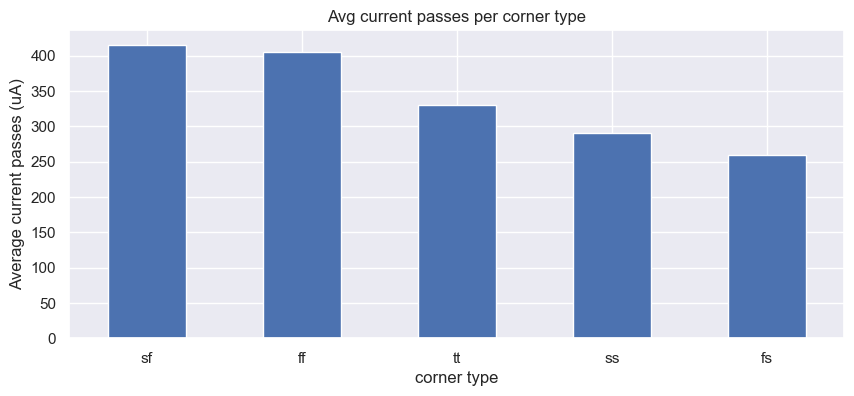

In [127]:
plt.figure(figsize=(10, 4))
df_train.groupby('corner').mean().id.sort_values(ascending=False).plot(kind='bar');
plt.title('Avg current passes per corner type');
plt.xlabel('corner type');
plt.ylabel('Average current passes (uA)');
plt.xticks(rotation=0);

> Notably, the 'corner' category `sf` demonstrates the highest mean 'id' value at `415.105`, indicating that this\
corner type tends to result in the highest transistor current on average. Conversely, the 'corner' category `fs` has the lowest mean 'id' value at `259.326`, suggesting a lower average transistor current.

#### Q4) Which features are the best predictors for the current value?

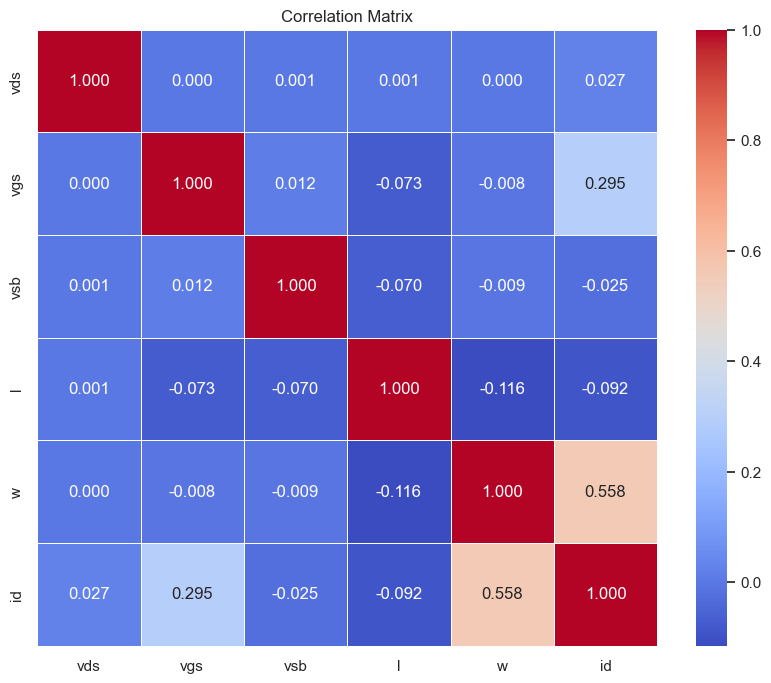

In [128]:
plt.figure(figsize=(10, 8))

correlation_matrix = df_train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".3f");
plt.title('Correlation Matrix');

> * There are just 2 features with a slightly significant relation ot the Id.
>   * `width (w)` & `vgs`

> But we could consider some **Feature Engineering** to make more informative features, such as `making compinations of features`
> * width / lenght.
> * Vgs - Vds
> * Vgs * Vds

In [129]:
df_train = add_compination_of_features(df_train)
df_test  = add_compination_of_features(df_test)

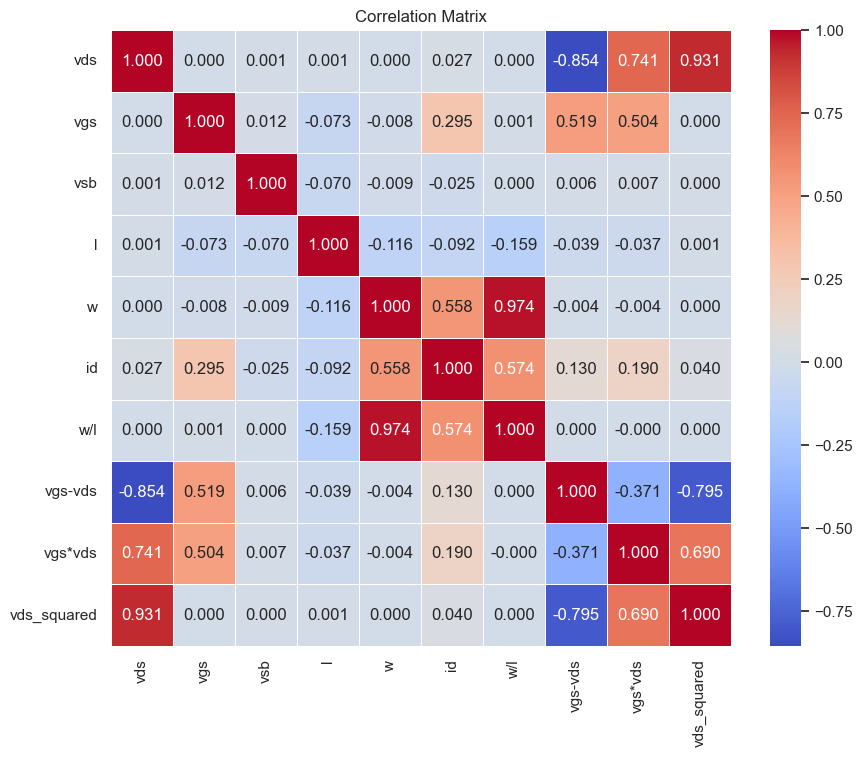

In [130]:
plt.figure(figsize=(10, 8))

correlation_matrix = df_train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".3f");
plt.title('Correlation Matrix');

> We could see that there is slightly related features to the Id were added.

> Converting the categorical feature `corner` to numeric values.

In [131]:
df_train = pd.get_dummies(df_train, columns=['corner'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['corner'], drop_first=True)

> Getting feature importance from the Random Forests algorithm.

In [463]:
from sklearn.ensemble import RandomForestRegressor
feature_importance_model = RandomForestRegressor(n_estimators=100, random_state=SEED, n_jobs=-1)
feature_importance_model.fit(X=df_train.drop(columns=['id']), y=df_train.id)

RandomForestRegressor(n_jobs=-1, random_state=1234)

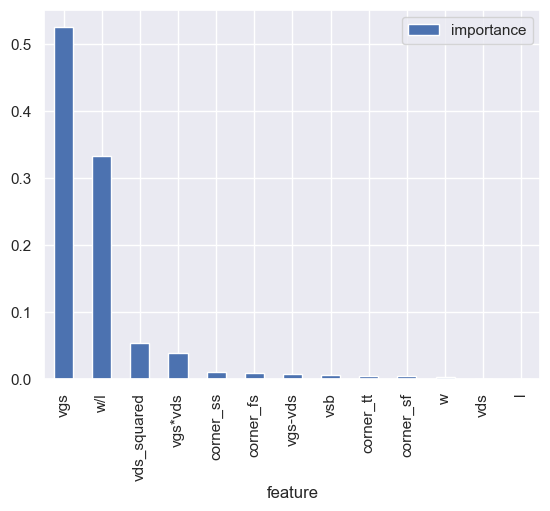

In [464]:
feature_importance = feature_importance_model.feature_importances_
dd = pd.DataFrame({'feature': df_train.drop(columns=['id']).columns, 'importance': feature_importance})
dd.sort_values(by='importance', ascending=False).plot(x='feature', y='importance', kind='bar');

> Droping not important features.

In [132]:
df_train.drop(columns=['l', 'vds', 'w', 'corner_tt'], inplace=True)
df_test.drop(columns=['l', 'vds', 'w', 'corner_tt'], inplace=True)

## Modeling

### Evaluation Matrix [WMAPE]
> When evaluating the performance of our model, we will use the **Weighted Mean Absolute Percentage Error (WMAPE)** as our primary metric. WMAPE takes into account the problem of having true values = 0 as in our case here as there are many readings with Id = 0.

The formula for WMAPE is as follows:

wmape.svg

In [133]:
def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

### 1) With XGBoost Regressor

In [134]:
# Intializing xgboost regressor
xgbr = xgb.XGBRegressor(
    objective='reg:squarederror',
    verbose=2
)

In [ ]:
# The space of search for best parameters
hyperparameter_grid = {
    'n_estimators': [100, 500, 900, 1100, 1500],
    'max_depth': [2, 3, 5, 10, 15],
    'learning_rate': [0.05, 0.1, 0.15, 0.20],
    'min_child_weight': [1, 2, 3, 4]
    }

# Making a scorer with our wmape
metric = make_scorer(wmape, greater_is_better=False)

random_search = RandomizedSearchCV(
    estimator=xgbr,
    param_distributions=hyperparameter_grid,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring=metric,
    random_state=SEED
)

random_search.fit(df_train.drop(columns='id'), df_train.id)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


> After training for 2 hours, The best params were:

{'n_estimators': 100,
 'min_child_weight': 1,
 'max_depth': 10,
 'learning_rate': 0.1}

In [136]:
best_estimator = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators = 100,
    min_child_weight = 1,
    max_depth = 10,
    learning_rate = 0.1,
)

best_estimator.fit(df_train.drop(columns='id'), df_train.id)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [137]:
y_pred = best_estimator.predict(df_test.drop(columns='id'))
y_pred[y_pred < 0] = 0

In [138]:
# Calculate the Weighted Mean Absolute Percentage Error (WMAPE) on the test_set
wmape(df_test.id, y_pred)

0.057602979426384864

##### WMAPE = 0.0576

In [139]:
with open('../Models/xgboost_wmape_00576.pkl', 'wb') as model_file:
    pickle.dump(xgbr, model_file)

### 2) With Neural Networks

In [140]:
# Just make it with torch tensors
def wmape(y_true, y_pred):
    return torch.sum(torch.abs(y_true - y_pred)) / torch.sum(torch.abs(y_true))

#### Preprocessing
* Standarization
* Splitting the data into [train, validation, test]


In [141]:
df_train, df_validation = train_test_split(df_train, test_size=0.2, random_state=SEED)

scaler_train = StandardScaler()
scaler_validation = StandardScaler()
scaler_test = StandardScaler()

x_train = scaler_train.fit_transform(df_train.drop(columns='id'))
y_train = np.array(df_train.id)

x_validation = scaler_validation.fit_transform(df_validation.drop(columns='id'))
y_validation = np.array(df_validation.id)

x_test = scaler_test.fit_transform(df_test.drop(columns='id'))
y_test = np.array(df_test.id)

In [147]:
print(f'Train set: {df_train.shape}')
print(f'Validation set: {df_validation.shape}')
print(f'Test set: {df_test.shape}')

Train set: (557752, 10)
Validation set: (139438, 10)
Test set: (174298, 10)


#### Data Loader

In [162]:
class MOS_Dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        
        return x, y


x_train_tensors = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train_tensors = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device)

x_val_tensors = torch.tensor(x_validation, dtype=torch.float32).to(device)
y_val_tensors = torch.tensor(y_validation, dtype=torch.float32).reshape(-1, 1).to(device)

x_test_tensors = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test_tensors = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).to(device)

train_dataset = MOS_Dataset(x_train_tensors, y_train_tensors)
valid_dataset = MOS_Dataset(x_val_tensors, y_val_tensors)
test_dataset  = MOS_Dataset(x_test_tensors, y_test_tensors)

train_loader  = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader  = DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_loader   = DataLoader(test_dataset, batch_size=64)

#### MOS model

In [174]:
class MOS_model(nn.Module):
    def __init__(self, input_size):
        super(MOS_model, self).__init__()
        
        # Define the layers
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 1) # Output layer

        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        output = self.relu(self.fc6(x))  # Relu output layer, as No Current Id < 0.
        
        return output

model = MOS_model(df_train.shape[1] - 1).to(device)

#### Training Process & Evaluation

> Configrations

In [175]:
criterion = wmape
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.750)

num_epochs = 20
num_train_batchs = len(train_loader)
train_losses = []
val_losses = []
best_val_loss = float('inf')

# Number of epochs val_loss didn't decreased befor early stoppingcounter = 0
counter = 0

# Max number of epochs val_loss didn't decreased befor early stopping
patience = 5

# Saving model function
import os
checkpoint_dir = "../Models/pytorch_checkpoints"

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    
def save_checkpoint(model, optimizer, epoch, best_val_loss):
    best_val_loss = str(round(best_val_loss, 3)).replace('.', '')
    checkpoint_path = os.path.join(checkpoint_dir, f'pytoch_wmape_{best_val_loss}.pt')
    torch.save({
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'epoch': epoch
     }, checkpoint_path)

    print('Model saved :)')

def save_best_model(model, best_val_loss):
    best_val_loss = str(round(best_val_loss, 3)).replace('.', '')
    path = os.path.join('../Models/', f'pytoch_wmape_{best_val_loss}.pt')
    torch.save({
      'model_state_dict': model.state_dict(),
     }, path)


In [176]:
def train(model, optimizer, criterion, train_loader):
    model.train()
    running_loss = 0.0
    for i, (x, y) in tqdm(enumerate(train_loader), total=num_train_batchs, desc='Training'):
        optimizer.zero_grad()

        # Forward pass
        output = model(x)
        loss = criterion(y, output)

        # Backward pass
        loss.backward()
        
        # Updating parameters
        optimizer.step()

        # Monitoring
        running_loss += loss.item()
        
    return running_loss / len(train_loader)

def evaluate(model, criterion, val_loader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for x, y in valid_loader:
            output = model(x)
            loss = criterion(y, output)
            running_loss += loss.item()
            
    return running_loss / len(val_loader)

def test(model, criterion, test_loader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            output = model(x)
            loss = criterion(y, output)
            running_loss += loss.item()
            
    return running_loss / len(test_loader)

In [177]:
for epoch in range(num_epochs):
    # Training phase
    train_loss = train(model, optimizer, criterion, train_loader)
    train_losses.append(train_loss)
    
    # Evaluation phase
    print('Validating ...')
    val_loss = evaluate(model, criterion, valid_loader)
    val_losses.append(val_loss)
    
    # Printing and monitoring
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model)
        save_checkpoint(best_model, optimizer, epoch, best_val_loss)
        counter = 0
        
    else:
        counter += 1
        if counter >= patience:
            print(f'Validation loss did not improve for {patience} epochs. Stopping early.')
            break
        if counter in range(2, patience+1, 2):
            scheduler.step()
            print(f"Learning rate decreased!, now is {optimizer.state_dict()['param_groups'][0]['lr']}")
        

save_best_model(best_model, best_val_loss)

Training: 100%|███████████████████████████████████████████████████████████████████| 8715/8715 [00:34<00:00, 249.05it/s]


Validating ...
Epoch [1/20], Train Loss: 1.0000, Validation Loss: 1.0000
Model saved :)


Training:   7%|████▍                                                               | 573/8715 [00:02<00:31, 260.95it/s]


KeyboardInterrupt: 

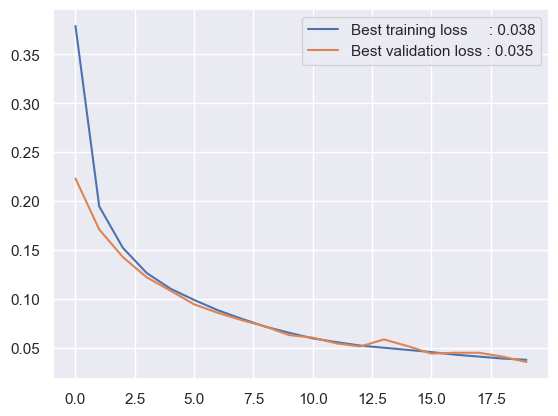

In [77]:
plt.plot(train_losses, label=f'Best training loss     : {min(train_losses):.3f}');
plt.plot(val_losses, label=f'Best validation loss : {min(val_losses):.3f}');
plt.xlabel('Epochs');
plt.ylabel('wmape loss');
plt.legend();

In [75]:
print(f'Generalization loss: {test(best_model, wmape, test_loader)}')

Generalization loss: 0.03768510859125949


> Lets take another 20 epochs of trainin, but with minimum learning rate.

In [78]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
counter = 0

for epoch in range(num_epochs):
    # Training phase
    train_loss = train(model, optimizer, criterion, train_loader)
    train_losses.append(train_loss)
    
    # Evaluation phase
    print('Validating ...')
    val_loss = evaluate(model, criterion, valid_loader)
    val_losses.append(val_loss)
    
    # Printing and monitoring
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model)
        save_checkpoint(best_model, optimizer, epoch, best_val_loss)
        counter = 0
        
    else:
        counter += 1
        if counter >= patience:
            print(f'Validation loss did not improve for {patience} epochs. Stopping early.')
            break
        if counter in range(2, patience+1, 2):
            scheduler.step()
            print(f"Learning rate decreased!, now is {optimizer.state_dict()['param_groups'][0]['lr']}")
        

save_best_model(best_model, best_val_loss)

Training: 100%|███████████████████████████████████████████████████████████████████| 8171/8171 [00:27<00:00, 300.41it/s]


Validating ...
Epoch [1/20], Train Loss: 0.0339, Validation Loss: 0.0343
Model saved :)


Training: 100%|███████████████████████████████████████████████████████████████████| 8171/8171 [00:24<00:00, 330.66it/s]


Validating ...
Epoch [2/20], Train Loss: 0.0332, Validation Loss: 0.0355


Training: 100%|███████████████████████████████████████████████████████████████████| 8171/8171 [00:25<00:00, 316.40it/s]


Validating ...
Epoch [3/20], Train Loss: 0.0324, Validation Loss: 0.0320
Model saved :)


Training: 100%|███████████████████████████████████████████████████████████████████| 8171/8171 [00:25<00:00, 325.72it/s]


Validating ...
Epoch [4/20], Train Loss: 0.0318, Validation Loss: 0.0326


Training: 100%|███████████████████████████████████████████████████████████████████| 8171/8171 [00:25<00:00, 324.90it/s]


Validating ...
Epoch [5/20], Train Loss: 0.0310, Validation Loss: 0.0377
Learning rate decreased!, now is 5e-05


Training: 100%|███████████████████████████████████████████████████████████████████| 8171/8171 [00:25<00:00, 324.36it/s]


Validating ...
Epoch [6/20], Train Loss: 0.0307, Validation Loss: 0.0306
Model saved :)


Training: 100%|███████████████████████████████████████████████████████████████████| 8171/8171 [00:27<00:00, 298.20it/s]


Validating ...
Epoch [7/20], Train Loss: 0.0299, Validation Loss: 0.0288
Model saved :)


Training: 100%|███████████████████████████████████████████████████████████████████| 8171/8171 [00:26<00:00, 313.40it/s]


Validating ...
Epoch [8/20], Train Loss: 0.0292, Validation Loss: 0.0317


Training: 100%|███████████████████████████████████████████████████████████████████| 8171/8171 [00:28<00:00, 288.56it/s]


Validating ...
Epoch [9/20], Train Loss: 0.0285, Validation Loss: 0.0306
Learning rate decreased!, now is 5e-05


Training: 100%|███████████████████████████████████████████████████████████████████| 8171/8171 [00:25<00:00, 318.74it/s]


Validating ...
Epoch [10/20], Train Loss: 0.0282, Validation Loss: 0.0303


Training: 100%|███████████████████████████████████████████████████████████████████| 8171/8171 [00:24<00:00, 330.49it/s]


Validating ...
Epoch [11/20], Train Loss: 0.0275, Validation Loss: 0.0282
Model saved :)


Training: 100%|███████████████████████████████████████████████████████████████████| 8171/8171 [00:25<00:00, 319.12it/s]


Validating ...
Epoch [12/20], Train Loss: 0.0274, Validation Loss: 0.0304


Training: 100%|███████████████████████████████████████████████████████████████████| 8171/8171 [00:25<00:00, 317.75it/s]


Validating ...
Epoch [13/20], Train Loss: 0.0267, Validation Loss: 0.0301
Learning rate decreased!, now is 5e-05


Training: 100%|███████████████████████████████████████████████████████████████████| 8171/8171 [00:25<00:00, 317.29it/s]


Validating ...
Epoch [14/20], Train Loss: 0.0263, Validation Loss: 0.0314


Training: 100%|███████████████████████████████████████████████████████████████████| 8171/8171 [00:26<00:00, 309.61it/s]


Validating ...
Epoch [15/20], Train Loss: 0.0260, Validation Loss: 0.0262
Model saved :)


Training: 100%|███████████████████████████████████████████████████████████████████| 8171/8171 [00:26<00:00, 310.74it/s]


Validating ...
Epoch [16/20], Train Loss: 0.0258, Validation Loss: 0.0264


Training: 100%|███████████████████████████████████████████████████████████████████| 8171/8171 [00:29<00:00, 281.74it/s]


Validating ...
Epoch [17/20], Train Loss: 0.0253, Validation Loss: 0.0340
Learning rate decreased!, now is 5e-05


Training: 100%|███████████████████████████████████████████████████████████████████| 8171/8171 [00:26<00:00, 306.11it/s]


Validating ...
Epoch [18/20], Train Loss: 0.0250, Validation Loss: 0.0378


Training: 100%|███████████████████████████████████████████████████████████████████| 8171/8171 [00:29<00:00, 277.75it/s]


Validating ...
Epoch [19/20], Train Loss: 0.0247, Validation Loss: 0.0283
Learning rate decreased!, now is 5e-05


Training: 100%|███████████████████████████████████████████████████████████████████| 8171/8171 [00:26<00:00, 311.94it/s]


Validating ...
Epoch [20/20], Train Loss: 0.0243, Validation Loss: 0.0264
Validation loss did not improve for 5 epochs. Stopping early.


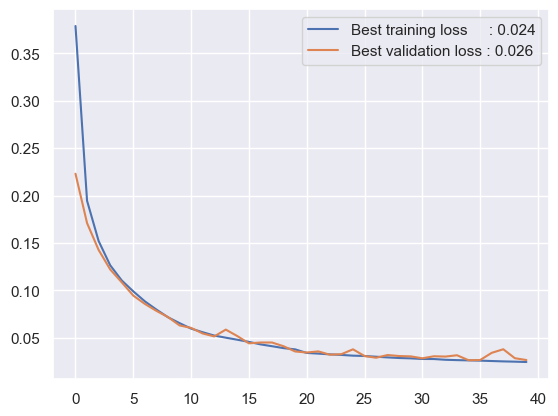

In [79]:
plt.plot(train_losses, label=f'Best training loss     : {min(train_losses):.3f}');
plt.plot(val_losses, label=f'Best validation loss : {min(val_losses):.3f}');
plt.legend();